In [1]:
import pandas as pd
import numpy as np
import glob,os
from glob import iglob
#import scanpy as sc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import joblib
import time
import random
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

# SLE data for machine learning

In [2]:
### training data import
sle_bulk=pd.read_csv('../RNA_seq_for_autoimmune_disease/SLE_bulk/GSE72509_SLE_RPKMs.txt.gz',sep='\t')
sle_bulk=sle_bulk.set_index('SYMBOL')
hd1=pd.read_csv('../RNA_seq_for_autoimmune_disease/health_bulk/GSE183204_HC_fpkm.csv',sep=',',index_col=0)


In [3]:
### feature import
features=pd.read_csv('../script4paper2/combined_gene_for_machine_learning.csv',index_col=1).index.values
features=np.append(features,'patient')

### validation SLE data import
test_sle=pd.read_csv('../RNA_seq_for_autoimmune_disease/GSE164457_SLE_fpkm.csv',index_col=0).T

### validation Healthy donor data import
hd2=pd.read_csv('../RNA_seq_for_autoimmune_disease/health_bulk/GSE169687_HC_fpkm.csv',sep=',',index_col=0)

hd3=pd.read_csv('../RNA_seq_for_autoimmune_disease/health_bulk/GSE169687_HC_24wk_fpkm.csv',sep=',',index_col=0)

### calculate intersection gene
features=[i for i in sle_bulk.index.values if i in features]
features=[i for i in features if i in hd2.index.values]
features=[i for i in features if i in test_sle.columns.values]


# remove unwanted gene

In [4]:
### remove unwanted gene from training data
sle_sub=sle_bulk.loc[features,:]
sle_part=sle_sub.loc[:,sle_sub.columns.str.startswith('SLE')].T
control_part=sle_sub.loc[:,sle_sub.columns.str.startswith('control')].T
hd1=hd1.loc[features,:].T

### remove unwanted gene from validation data
hd2=hd2.loc[features,:].T
hd3=hd3.loc[features,:].T
test_sle=test_sle.loc[:,features]



# label data

In [5]:
### label training data
sle_part['patient']=1
control_part['patient']=0
hd1['patient']=0

### label validation data
hd2['patient']=0
hd3['patient']=0


# machine learning data training

In [6]:
### merge training data
df=pd.concat([sle_part,control_part,hd1])

### get data labels
label=df.patient.values

### split data with ratio 30% for test and 70% for training
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df.drop(columns=['patient']),label,test_size=0.3)

### rf model initialization
rfc = RandomForestClassifier(random_state=43,class_weight='balanced',oob_score=True,n_estimators=190,max_features=7)
rfc = rfc.fit(Xtrain,Ytrain)

### document model score
score_r = rfc.score(Xtest,Ytest)

### save feature importance
sle_feature=pd.DataFrame(rfc.feature_importances_)
sle_feature['feature_importance']=features
sle_feature.to_csv('./model/sle_feature_importance_bulk.csv')

### print F score and Out of bag score
print("Random Forest:{}".format(score_r))
print("OOB score:",rfc.oob_score_)






Random Forest:0.9487179487179487
OOB score: 0.9


/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [88]:
print(sum(rfc.predict(test_sle)))
print(sum(rfc.predict(hd2.drop(columns=['patient']))))
print(sum(rfc.predict(hd3.drop(columns=['patient']))))


118
2
4


# Figure 6B

<ipython-input-21-0213e57c7eac>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figure6_and_7/6bsle_bulk_auc.pdf',width=4,height=5)
<ipython-input-21-0213e57c7eac>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figure6_and_7/6bsle_bulk_auc.pdf',width=4,height=5)


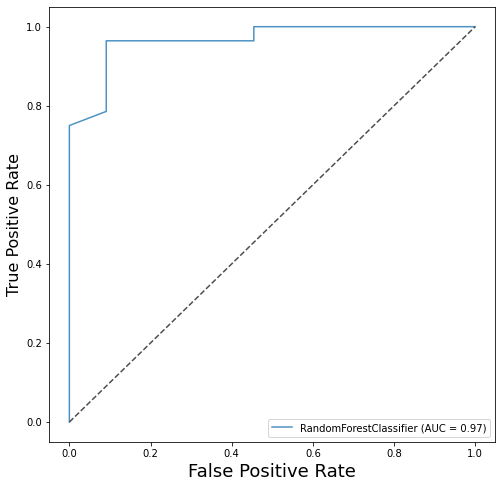

In [21]:
### Generating ROC curve
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, Xtest, Ytest, ax=ax, alpha=0.8)
plt.legend(loc=4,prop={'size': 10})
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=16)
ax.plot([0, 1], [0, 1], ls="--", c=".3")
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
plt.savefig('./figure6_and_7/6bsle_bulk_auc.pdf',width=4,height=5)

# save/load best performance model

In [834]:
### save the best performance model
#joblib.dump(rfc, './model/90_accuracy_for_both_120_sle_and_hd2_3.model')

### load model
#rfc=joblib.load('./model/sle_best.model')


In [677]:
### 10-fold cross validation
print(cross_val_score(rfc,df.drop(columns=['patient']),label,cv=10).mean())
print(cross_val_score(rfc,df.drop(columns=['patient']),label,cv=10).var())

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

0.9147435897435896


/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

0.0040766765285996055


/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Figure 8C

<ipython-input-8-4d2a565a5685>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([" ","","Predicted Health", "","","","Real Health"])


(array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ]),
 [Text(0.5, 0, ' '),
  Text(0.75, 0, ''),
  Text(1.0, 0, 'Predicted Health'),
  Text(1.25, 0, ''),
  Text(1.5, 0, ''),
  Text(1.75, 0, ''),
  Text(2.0, 0, 'Real Health'),
  Text(2.25, 0, ''),
  Text(2.5, 0, '')])

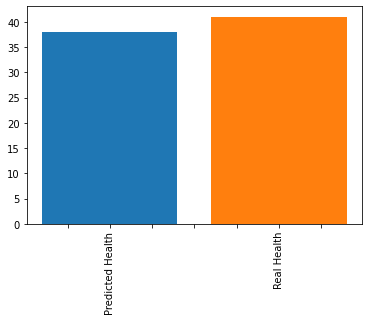

In [8]:
data1 = [38]
data2 = [41]
label=['Health','SLE']
plt.bar([1], height=data1, label='predicted number')
plt.bar([2],height=data2, label='real number')
plt.gca().set_xticklabels([" ","","Predicted Health", "","","","Real Health"])
plt.xticks(rotation = 90)
#plt.savefig('./figure6_and_7/6e_predicted.pdf',width=4,height=4)


In [ ]:
data1 = [ 120]
data2 = [ 120]
label=['Health','SLE']
plt.bar([1,3], height=data1, label='predicted number')
plt.bar([2,4],height=data2, label='real number')
plt.gca().set_xticklabels([" ","","Predicted Health", "","Real Health", "","Predicted SLE",'','Real SLE'])
plt.xticks(rotation = 90)
#plt.savefig('./figure6_and_7/6e_predicted.pdf',width=4,height=4)


# Figure 6D

<ipython-input-840-f9f6c4422873>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figure6_and_7/bulk_model_sle.pdf',width=15,height=5)
<ipython-input-840-f9f6c4422873>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figure6_and_7/bulk_model_sle.pdf',width=15,height=5)


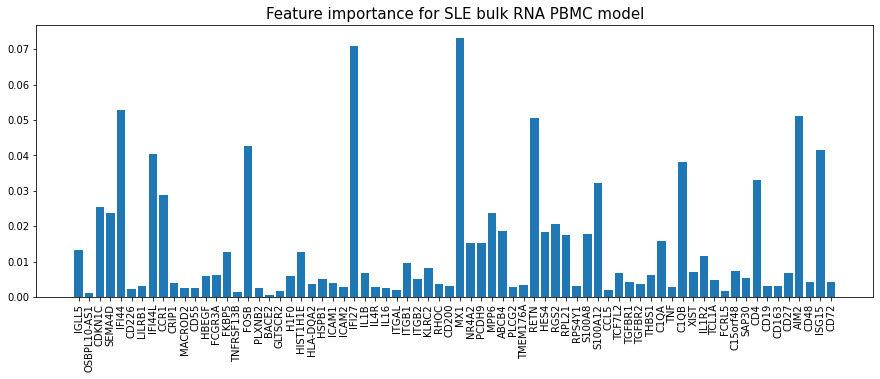

In [840]:
sle_feature=pd.read_csv('./model/sle_feature_importance_bulk.csv')
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x=a['feature_importance'], height=a[0])
ax.set_title("Feature importance for SLE bulk RNA PBMC model", fontsize=15)
plt.xticks(rotation = 90)
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
plt.savefig('./figure6_and_7/6c_bulk_model_sle.pdf',width=15,height=5)

# Hyper-parameter adjust

0.9307692307692308 191
Running time: 43.39305520057678 Seconds


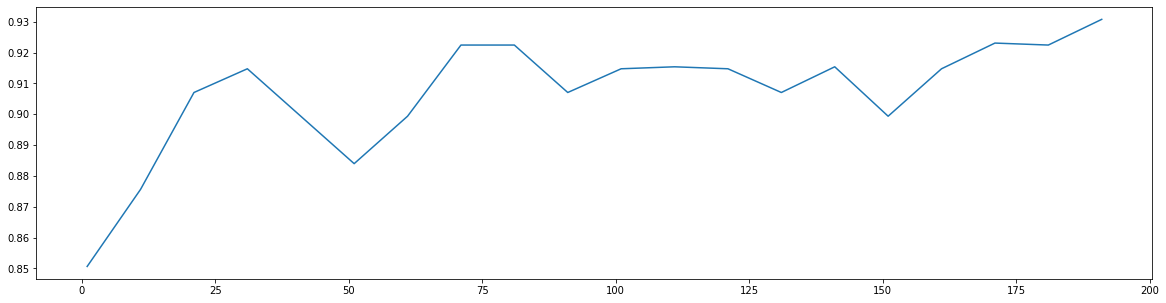

In [795]:
data=df.drop(columns=['patient'])
label=df.patient.values
start=time.time()
scorel = []
for i in range(0,200,10): # loop for 0-200 decision trees
    rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=0)
    score = cross_val_score(rfc,data,label,cv=10).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
end=time.time()
print('Running time: %s Seconds'%(end-start))
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

0.9307692307692308 190


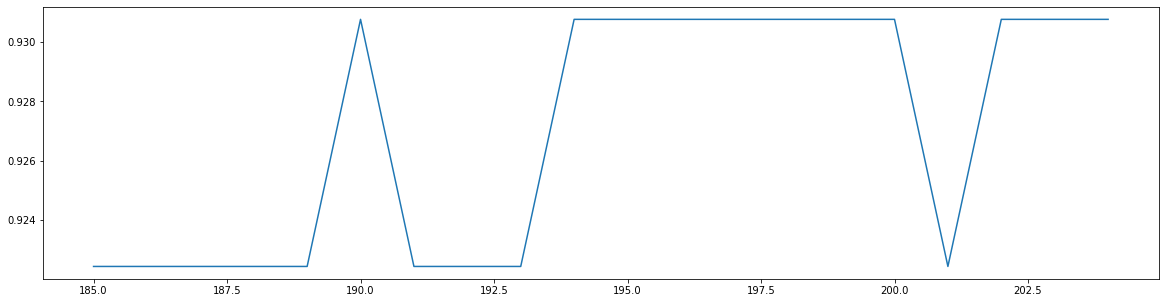

In [801]:
scorel = []
for i in range(185,205):
  rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=0)
  score = cross_val_score(rfc,data,label,cv=10).mean()
  scorel.append(score)
print(max(scorel),([*range(185,205)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(185,205),scorel)
plt.show()

In [802]:
start=time.time()
param_grid = {'max_depth':np.arange(1, 90,2)} 
alg = RandomForestClassifier(n_estimators=190,random_state=0) 
GS = GridSearchCV(alg,param_grid,cv=10) 
GS.fit(data,label)
print(GS.best_params_)
print(GS.best_score_)
end=time.time()
print('Running time: %s Seconds'%(end-start))


{'max_depth': 5}
0.923076923076923
Running time: 70.51941418647766 Seconds


In [803]:
start=time.time()
param_grid = {'max_features':np.arange(5,80,1)}
rfc = RandomForestClassifier(n_estimators=190,random_state=0)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data,label)
print(GS.best_params_)
print(GS.best_score_)
end=time.time()
print('Running time: %s Seconds'%(end-start))


{'max_features': 7}
0.9384615384615385
Running time: 149.39452290534973 Seconds


/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 442, in fit
    trees = Parallel(
  File "/home/pub1/miniconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/pub1/minic

# 100 loop of 10-fold cross validation

In [7]:
df_n=df.drop(columns=['patient'])
rfc_l = []
fpr_l=[]
tpr_l=[]
acc_l=[]
skf =StratifiedKFold(n_splits=10)
for i in range(100):
    for train_index, test_index in skf.split(df_n,label):
        rfc = RandomForestClassifier(random_state=0,class_weight="balanced",oob_score=True,n_estimators=190,max_features=7)
        rfc = rfc.fit(df_n.iloc[train_index],label[train_index])
        rfc_l.append(roc_auc_score(label[test_index], rfc.predict_proba(df_n.iloc[test_index])[:, 1]))
    #fpr_l.append(metrics.roc_curve(label[test_index],rfc.predict(df_n.iloc[test_index]), pos_label=1))
        acc_l.append(accuracy_score(label[test_index], rfc.predict(df_n.iloc[test_index])))
    
    

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/pub1/miniconda3/lib

In [8]:
### average AUC and its standard deviation error
print(np.mean(rfc_l))
print(np.std(rfc_l))

0.9983333333333333
0.004999999999999982
